# Analysis Notebook Template

Author(s): niall.bourke@kcl.ac.uk  , hajer.karoui@kcl.ac.uk
Version 2.5 (02/05/25)  

### Summary of Purpose:
This notebook serves as a structured template for conducting data analysis.
It centralizes common functionalities, such as data loading, visualization, and statistical analysis, into well-defined and reusable cells.
Each cell is modular, enabling easy customization and adaptation for different datasets or projects.

### Contents:
1. **Importing Packages**: A cell dedicated to importing all necessary libraries such as pandas, numpy, matplotlib, and seaborn.

2. **Defining Global Settings**: A cell to define consistent global settings, such as plot aesthetics (color palette, font size) and configurations for the notebook.

3. **Pulling CSV Files from the 'Information Tab'**: A cell that loads and processes CSV files from a specific source directory or tab, preparing them for analysis.

4. **Pulling Files from Analysis Output Containers**: A cell for retrieving and organizing files or results generated from other analysis pipelines or tools.

5. **Boxplot Function**: Contains a reusable function for generating boxplots with optional enhancements, such as overlaid scatter points or group-specific coloring.

6. **Scatterplot Function**: Contains a reusable function for creating scatterplots with regression lines, including options to group data and calculate correlation coefficients.

7. **Descriptive Statistics Function**: A cell with functions to compute descriptive statistics (e.g., mean, median, standard deviation), grouped statistics, frequency counts, and correlations.

8. **Miscellaneous Commands**: A collection of utility commands and helper functions that may be useful during the analysis, such as formatting outputs, handling missing data, or additional visualizations.


### Import packages

In [5]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from scipy.interpolate import CubicSpline
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor
from patsy import dmatrix
import statsmodels.api as sm
from matplotlib.patches import Patch



### Define global plot and display settings

Not all columns are usually displayed when printing the dataframe. To help us visualise the data better, we will remove this cap.

In [2]:
pd.set_option('display.max_columns', None)

In [6]:

# Define global plot settings
PLOT_FONT = "DejaVu Sans"    # Font family
PLOT_SIZE = (10, 6)          # Default figure size
COLOR_PALETTE = "Set2"       # Default color palette "Spectral"    
POINT_SIZE = 50              # Default point size for scatterplots
LINE_WIDTH = 2               # Default line width
TITLE_FONT_SIZE = 16         # Font size for titles
LABEL_FONT_SIZE = 14         # Font size for axis labels
TICK_FONT_SIZE = 12          # Font size for ticks

# Apply global Seaborn theme
sns.set_theme(
    style="whitegrid",
    context="notebook",
    font=PLOT_FONT,
    palette=COLOR_PALETTE
)

# Set Matplotlib defaults
plt.rcParams.update({
    "figure.figsize": PLOT_SIZE,
    "axes.titlesize": TITLE_FONT_SIZE,
    "axes.labelsize": LABEL_FONT_SIZE,
    "xtick.labelsize": TICK_FONT_SIZE,
    "ytick.labelsize": TICK_FONT_SIZE,
    "lines.linewidth": LINE_WIDTH
})

print("Global plot settings applied.")


Global plot settings applied.


### This cell pulls derived values from csv files stored in the infomation tab

In [ ]:
# Specify name of file you want to download to env
volumetrics = 'sample-recon-all-clinical-0.3.2-volumes.csv'
metadata = 'sample-session-info-synthetic.csv'

# Specify an object that contains the files in the information tab
file_obj = fw_project.files

# Loop over each file in this object until you find the file of interest
for file in file_obj:
    if volumetrics in file.name:
        download_path = Path.home() / "Data/" / file.name
        file.download(download_path)
        df = pd.read_csv(download_path)
    elif metadata in file.name:
        download_path = Path.home() / "Data/" / file.name
        file.download(download_path)
        metadata_df = pd.read_csv(download_path)


#This is a csv combining both volumetrics and metadata
metadata_df.rename(columns={"sex_at_birth": "sex","age_at_scan_months": "age"}, inplace=True)

combined_df = pd.merge(df, metadata_df, on=['subject_label',"sex","age"], how='inner')
combined_df["total_intracranial_norm"] = combined_df["total_intracranial"] / combined_df["current_hc_cm"]

combined_df["total_intracranial_norm"] = combined_df["total_intracranial"] / combined_df["current_hc_cm"]

In [ ]:
# df = pd.read_csv("/Users/Hajer/unity/fw-notebooks/Data/sample-recon-all-clinical-0.3.2-volumes.csv")
# metadata_df = pd.read_csv("/Users/Hajer/unity/fw-notebooks/Data/sample-session-info-synthetic.csv")

# metadata_df.rename(columns={"sex_at_birth": "sex","age_at_scan_months": "age"}, inplace=True)

# combined_df = pd.merge(df, metadata_df, on=['subject_label',"sex","age"], how='inner')
# combined_df["total_intracranial_norm"] = combined_df["total_intracranial"] / combined_df["current_hc_cm"]

### This cell pulls the most recent output for a specified gear run
*At least by date

In [ ]:
# Define gear
gear='form-parser'

# Filter the analyses by the gear name
analyses = fw_project.analyses
gear_to_find = gear.strip()  # Assuming 'gear' is the gear name you're looking for
filtered_gear_runs = [
    run for run in analyses
    if run.get('gear_info', {}).get('name', '').strip().casefold() == gear_to_find.casefold()
]

# Get the latest gear run
latest_gear_run = filtered_gear_runs[-1]
file_object = latest_gear_run.files
print("File object: ", file_object[0].name)

# Download file
download_path = Path.home() / "Data/" / file_object[0].name
file_object[0].download(download_path)

# After download specify as variable to view
df_qc = download_path

File object:  parsed_qc_annotations_2024-12-12_14-44-40.csv


### unity_boxplot function
Setup with defaults, allows user to specify what variables they want to display

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def unity_boxplot(data=None, x_axis='default_x', y_axis='default_y', title="Plot Title"):
    """
    Plots data using Seaborn boxplot with scatter points overlaid, 
    where points are colored based on the x-axis variable.

    Parameters:
        data (pd.DataFrame): The dataset to plot.
        x_axis (str): The column name for the x-axis. Defaults to 'default_x'.
        y_axis (str): The column name for the y-axis. Defaults to 'default_y'.
        title (str): Title of the plot. Defaults to "Plot Title".

    Returns:
        None
    """
    
    if data is None:
        print("No input data provided. Please use the function as shown in the example below:")
        print("""
        Example Usage:
        ---------------
        
        unity_boxplot(df, x_axis='sex', y_axis='total intracranial', title='Boxplot')
        
        Example dataset:
        ---------------
                
        df = pd.DataFrame({
        'Category': ['A', 'B', 'A', 'B', 'C', 'C', 'A', 'B', 'C', 'A'],
        'Values': [5, 7, 6, 8, 5, 7, 6, 8, 6, 7]
        })


        """)
        return
    
    if x_axis not in data.columns or y_axis not in data.columns:
        raise ValueError(f"Specified axes '{x_axis}' or '{y_axis}' not found in the dataset columns.")

    # Create the boxplot
    sns.boxplot(
        data=data,
        x=x_axis,
        y=y_axis,
        palette=COLOR_PALETTE #"Set2"  # Use a qualitative palette for x-axis categories
    )
    
    # Overlay the points with coloring by x-axis variable
    sns.stripplot(
        data=data,
        x=x_axis,
        y=y_axis,
        hue=x_axis,  # Points colored by the x-axis variable
        # dodge=True,  # Spread points out slightly
        palette=COLOR_PALETTE,  # Same palette for consistency
        size=8,
        jitter=True,
        alpha=0.8  # Make points slightly transparent for visibility
    )

    # Add labels, legend, and title
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    plt.legend(title=x_axis, bbox_to_anchor=(1.05, 1), loc="upper left")  # Place legend outside the plot
    plt.tight_layout()
    plt.savefig(f'{x_axis}_boxplot.png')
    plt.show()


### Call boxplot function
Required inputs:
- dataframe
- X axis variable (categorical)
- Y axis variable (continuous)

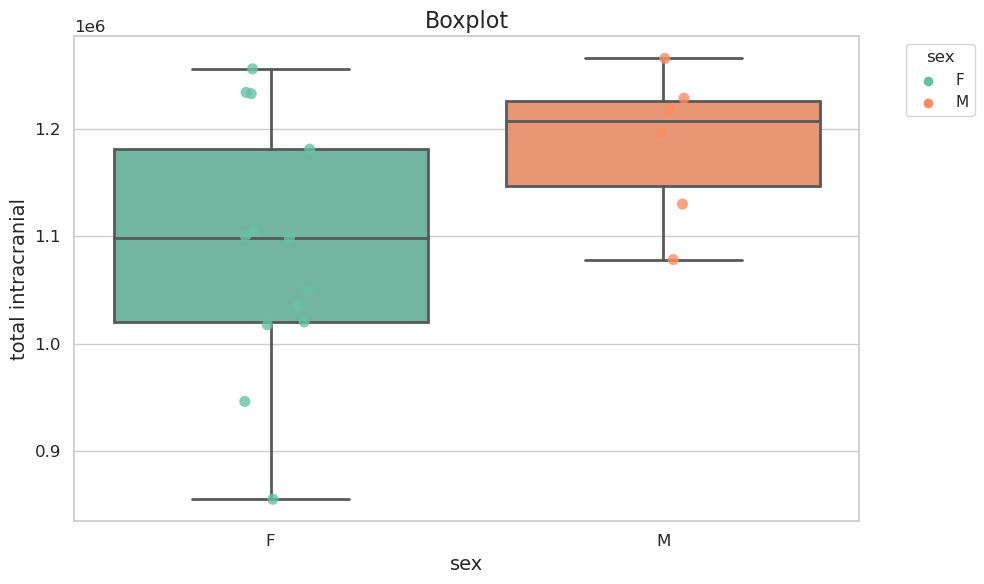

In [82]:
unity_boxplot(df, x_axis='sex', y_axis='total intracranial', title='Boxplot')

**Usage example if no inputs are provided** 

In [83]:
unity_boxplot()

No input data provided. Please use the function as shown in the example below:

        Example Usage:
        ---------------
        
        unity_boxplot(df, x_axis='sex', y_axis='total intracranial', title='Boxplot')
        
        Example dataset:
        ---------------
                
        df = pd.DataFrame({
        'Category': ['A', 'B', 'A', 'B', 'C', 'C', 'A', 'B', 'C', 'A'],
        'Values': [5, 7, 6, 8, 5, 7, 6, 8, 6, 7]
        })


        


### Scatter plot function

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

def unity_scatterplot(data=None, x_axis='default_x', y_axis='default_y', group=None, title="Plot Title"):
    """
    Plots data using Seaborn lmplot for scatter points with regression lines, 
    where points are optionally colored based on a grouping variable. 
    Includes r and p values for each group on the plot.

    Parameters:
        data (pd.DataFrame): The dataset to plot.
        x_axis (str): The column name for the x-axis. Defaults to 'default_x'.
        y_axis (str): The column name for the y-axis. Defaults to 'default_y'.
        group (str): The column name for the grouping variable. Defaults to None.
        title (str): Title of the plot. Defaults to "Plot Title".

    Returns:
        None
    """
    if data is None:
        print("No input data provided. Please use the function as shown in the example below:")
        print("""
        Example Usage:
        ---------------
        
        unity_scatterplot(df, x_axis='age', y_axis='total_intracranial', group='sex', title='Smoothed Regression Plot')
        
        Example dataset:
        ---------------
                
        df = pd.DataFrame({
            'age': [20, 25, 30, 35, 40, 45, 50, 55, 60, 65],
            'total_intracranial': [1500, 1520, 1480, 1450, 1400, 1380, 1350, 1330, 1300, 1280],
            'sex': ['M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F']
        })
        """)
        return

    if x_axis not in data.columns or y_axis not in data.columns:
        raise ValueError(f"Specified axes '{x_axis}' or '{y_axis}' not found in the dataset columns.")

    # Calculate r and p values for each group if a grouping variable is provided
    annotations = []
    if group:
        grouped_data = data.groupby(group)
        for group_name, group_data in grouped_data:
            x = group_data[x_axis]
            y = group_data[y_axis]
            r_value, p_value = pearsonr(x, y)
            annotations.append((group_name, r_value, p_value))
    else:
        # If no group, calculate for the entire dataset
        x = data[x_axis]
        y = data[y_axis]
        r_value, p_value = pearsonr(x, y)
        annotations.append((None, r_value, p_value))

    # Create the regression plot
    sns.lmplot(
        data=data, 
        x=x_axis, 
        y=y_axis, 
        hue=group, 
        ci=95, 
        height=6, 
        aspect=1.5, 
        scatter_kws={"s": 50}, 
        line_kws={"lw": 2}
    )

    # Add labels, title, and annotations
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    
    for idx, (group_name, r_value, p_value) in enumerate(annotations):
        text = f"{group_name if group_name else 'Overall'}: r = {r_value:.2f}, p = {p_value:.3g}"
        plt.annotate(
            text,
            xy=(0.05, 0.95 - idx * 0.05),
            xycoords='axes fraction',
            fontsize=12,
            ha='left',
            va='top',
            bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
        )

    plt.tight_layout()
    plt.savefig(f'scatterplot_{x_axis}_{y_axis}.png')
    plt.show()


### Call scatterplot function
Required inputs:
- dataframe
- X axis variable (continuous)
- Y axis variable (continuous)

Optional inputs:
- group (categorical)
- title

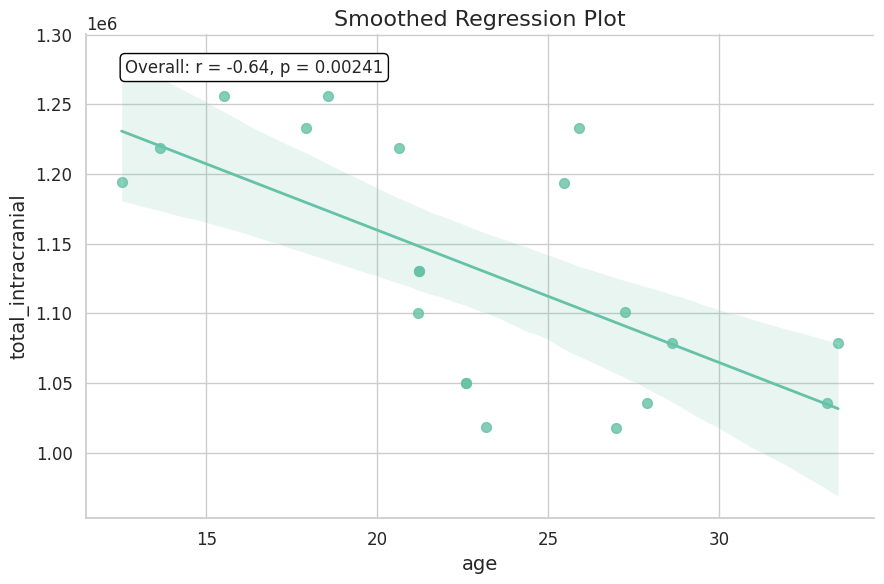

In [57]:
unity_scatterplot(df, x_axis='age', y_axis='total_intracranial', title='Smoothed Regression Plot')

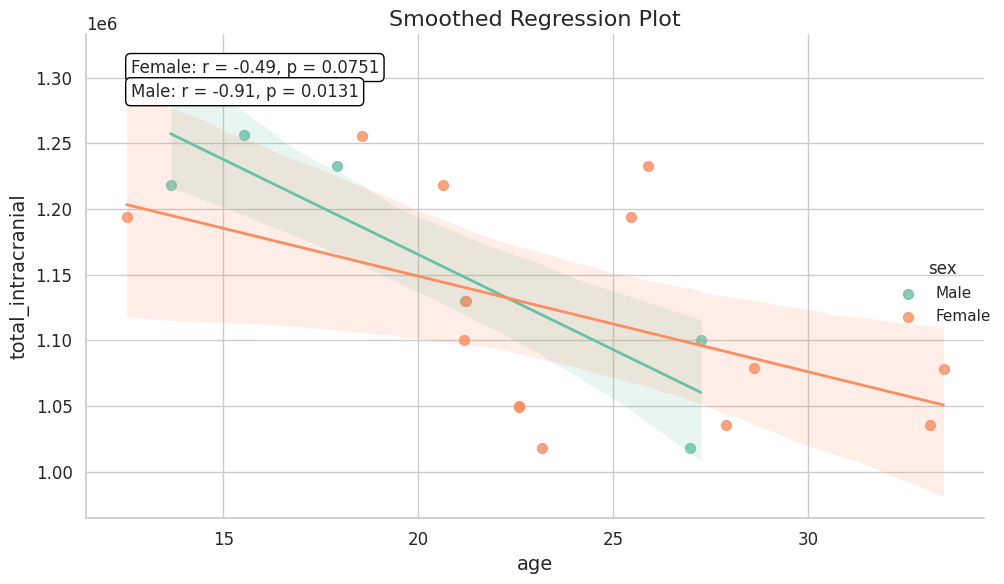

In [56]:
unity_scatterplot(df, x_axis='age', y_axis='total_intracranial', group='sex', title='Smoothed Regression Plot')

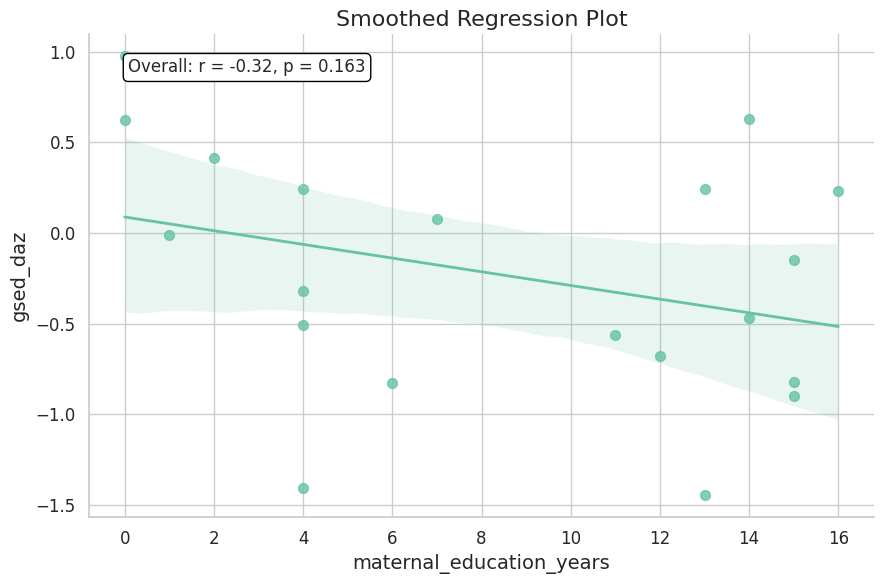

In [58]:
unity_scatterplot(combined_df, x_axis='maternal_education_years', y_axis='gsed_daz', title='Smoothed Regression Plot')

## Functions for descriptive statistics

In [ ]:
def dataset_summary(df):
    """
    Provides a summary of the entire dataset, including column data types, 
    missing values, and basic descriptive statistics.
    """
    print("Dataset Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nBasic Descriptive Statistics:")
    print(df.describe(include="all"))

    numerical_cols = df.select_dtypes(include=[np.number]).columns
    n_cols = 3  # Set number of columns in grid
    n_vars = len(numerical_cols)
    n_rows = math.ceil(n_vars / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(numerical_cols):
        sns.histplot(df[col], kde=True, ax=axes[i])
        axes[i].set_title(f"Distribution of {col}")

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


In [8]:
def grouped_statistics(data, group_column, numeric_columns):
    """
    Provides descriptive statistics for numeric columns grouped by a specific column.

    Parameters:
        data (pd.DataFrame): The dataset to analyze.
        group_column (str): The column to group by (e.g., 'group' or 'sex').
        numeric_columns (list): List of numeric columns to summarize (e.g., ['age', 'volume', 'weight']).
    """
    grouped_stats = data.groupby(group_column)[numeric_columns].describe()
    print(f"Descriptive Statistics Grouped by {group_column}:")
    print(grouped_stats)


In [90]:
def correlation_matrix(data, numeric_columns):
    """
    Calculates the correlation matrix for numeric columns in the dataset.

    Parameters:
        data (pd.DataFrame): The dataset to analyze.
        numeric_columns (list): List of numeric columns to include in the correlation matrix.
    """
    print("Correlation Matrix:")
    print(data[numeric_columns].corr())


In [4]:
def frequency_counts(data, categorical_columns):
    """
    Displays frequency counts for categorical columns in the dataset.

    Parameters:
        data (pd.DataFrame): The dataset to analyze.
        categorical_columns (list): List of categorical columns to summarize (e.g., ['group', 'sex']).
    """
    for column in categorical_columns:
        print(f"Frequency Counts for {column}:")
        print(data[column].value_counts())
        print()

        plt.figure(figsize=(6, 4))
        sns.countplot(x='Overall Success of Hyperfine', data=df, palette="viridis")
        plt.title("Hyperfine Imaging Success")
        plt.xlabel("Success")
        plt.ylabel("Count")
        plt.savefig(f'{column}_countplot.png')
        plt.show()


In [3]:
def plot_distribution(data,column):

    # Distribution of the specified variable
    plt.figure(figsize=(8, 6))
    sns.histplot(data[column].dropna(), bins=20, kde=True, color="blue")
    plt.title(f"Distribution of {column}")
    plt.xlabel(f"{column}]")
    plt.ylabel("Frequency")
    plt.savefig(f'{column}_histplot.png')
    plt.show()

In [92]:
def percentile_summary(data, column, percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]):
    """
    Calculates custom percentiles for a numeric column.

    Parameters:
        data (pd.DataFrame): The dataset to analyze.
        column (str): The numeric column to calculate percentiles for.
        percentiles (list): List of percentiles to calculate (default: [10th, 25th, 50th, 75th, 90th]).
    """
    print(f"Percentiles for {column}:")
    print(data[column].quantile(percentiles))


### Run descriptive statistics functions

In [101]:
# Run functions

sample_data = Path.home() / "Data/sample-recon-all-clinical-0.3.2-volumes.csv"
df = pd.read_csv(sample_data)
    
dataset_summary(df)
print('---')
grouped_statistics(df, group_column='sex', numeric_columns=['age', 'total intracranial', 'weight'])
print('---')
correlation_matrix(df, numeric_columns=['age', 'total intracranial', 'weight'])
print('---')
frequency_counts(df, categorical_columns=['group', 'sex'])
print('---')
percentile_summary(df, column='age')


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   subject             20 non-null     object
 1   session             20 non-null     object
 2   age                 20 non-null     int64 
 3   sex                 20 non-null     object
 4   group               20 non-null     object
 5   weight              20 non-null     int64 
 6   total intracranial  20 non-null     int64 
dtypes: int64(3), object(4)
memory usage: 1.2+ KB
None

Missing Values:
subject               0
session               0
age                   0
sex                   0
group                 0
weight                0
total intracranial    0
dtype: int64

Basic Descriptive Statistics:
           subject   session          age  sex    group     weight   
count           20        20    20.000000   20       20  20.000000  \
unique          20         1

In [4]:
def plot_distribution(df):
    """
    Plots the distribution of numeric columns in the dataset.

    Parameters:
        data (pd.DataFrame): The dataset to analyze.

    Returns:
        None
    """
    print(df.describe(include='all'))

    # Histograms
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    n_cols = 3  # Set number of columns in grid
    n_vars = len(numerical_cols)
    n_rows = math.ceil(n_vars / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(numerical_cols):
        sns.histplot(df[col], kde=True, ax=axes[i])
        axes[i].set_title(f"Distribution of {col}")

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_birth_weight(df):

    # Boxplots by Sex
    n_cols = 3  # Set number of columns in grid
    
    
    cols = ["total_intracranial_norm", "birth_weight_kg", "current_height_cm"]
    n_vars = len(cols)
    n_rows = math.ceil(n_vars / n_cols)


    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        plt.figure(figsize=(6, 4))
        sns.boxplot(x="sex_at_birth", y=col, data=df, ax=axes[i], palette='Spectral')
        axes[i].set_title(f"Distribution of {col}")

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()

In [60]:
# --- Growth Curves using Splines --- #
def unity_growth_curve(df):
    palette = sns.color_palette("tab10")
    scatter_legend_elements = []

    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    axes = axes.flatten()
    titles = ["ICV Growth by Birth Weight Group", 
              "White Matter Growth by Birth Weight Group", 
              "Grey Matter Growth by Birth Weight Group"]
    
    bw_labels = ['Low (<2.5 kg)', 'Normal (2.5–3.5 kg)', 'High (>3.5 kg)']
    bw_groups = ['Low', 'Normal', 'High']
    
    var = 'birth_weight_kg'

    # Define birth weight bins and labels
    bw_bins = [0, 2.5, 3.5, df[var].max()]
    bw_labels = ['Low (<2.5 kg)', 'Normal (2.5–3.5 kg)', 'High (>3.5 kg)']

    # Assign birth weight groups
    df['bw_group'] = pd.cut(df[var], bins=bw_bins, labels=bw_groups)

    
    for i, var2 in enumerate(["total_intracranial_norm", "white_matter", "grey_matter"]):
        ax = axes[i]
        sns.lineplot(data=df, x='age', y=var2, estimator=None, units='subject_label', lw=1, alpha=0.1, ax=ax)

        for j, group in enumerate(bw_groups):
            sub_df = df[df['bw_group'] == group].dropna(subset=["age", var2])
            if len(sub_df) < 5:
                print(f"Not enough data points for group '{group}' in variable '{var2}'. Skipping.")
                continue

            try:
                color = palette[j]
                n_samples = len(sub_df)
                ax.scatter(sub_df["age"], sub_df[var2], color=color, alpha=0.4)

                # Add entry to legend for scatter plot outside the individual plots
                scatter_legend_elements.append(
                    Patch(facecolor=color, edgecolor='black', label=f"{bw_labels[j]} (n={n_samples})", alpha=0.8)
                )

                # Fit spline and plot
                x = dmatrix("bs(age, df=4)", {"age": sub_df["age"]}, return_type='dataframe')
                model = sm.OLS(sub_df[var2], x).fit()
                pred_x = np.linspace(sub_df["age"].min(), sub_df["age"].max(), 100)
                pred_x_spline = dmatrix("bs(age, df=4)", {"age": pred_x}, return_type='dataframe')
                ax.plot(pred_x, model.predict(pred_x_spline), linewidth=2, linestyle='--', color=color)

            except Exception as e:
                print(f"Error fitting spline for group '{group}': {e}")

        ax.set_title(titles[i])
        ax.set_xlabel("Age (Months)")
        ax.set_ylabel(var2.replace('_', ' ').title())

    # Place the legend outside the plot area (to the right)
    fig.legend(handles=scatter_legend_elements[:3], title="Birth Weight Groups", loc="lower left", 
               bbox_to_anchor=(1, 1), frameon=True)
    
    plt.tight_layout()
    plt.show()
    plt.close()





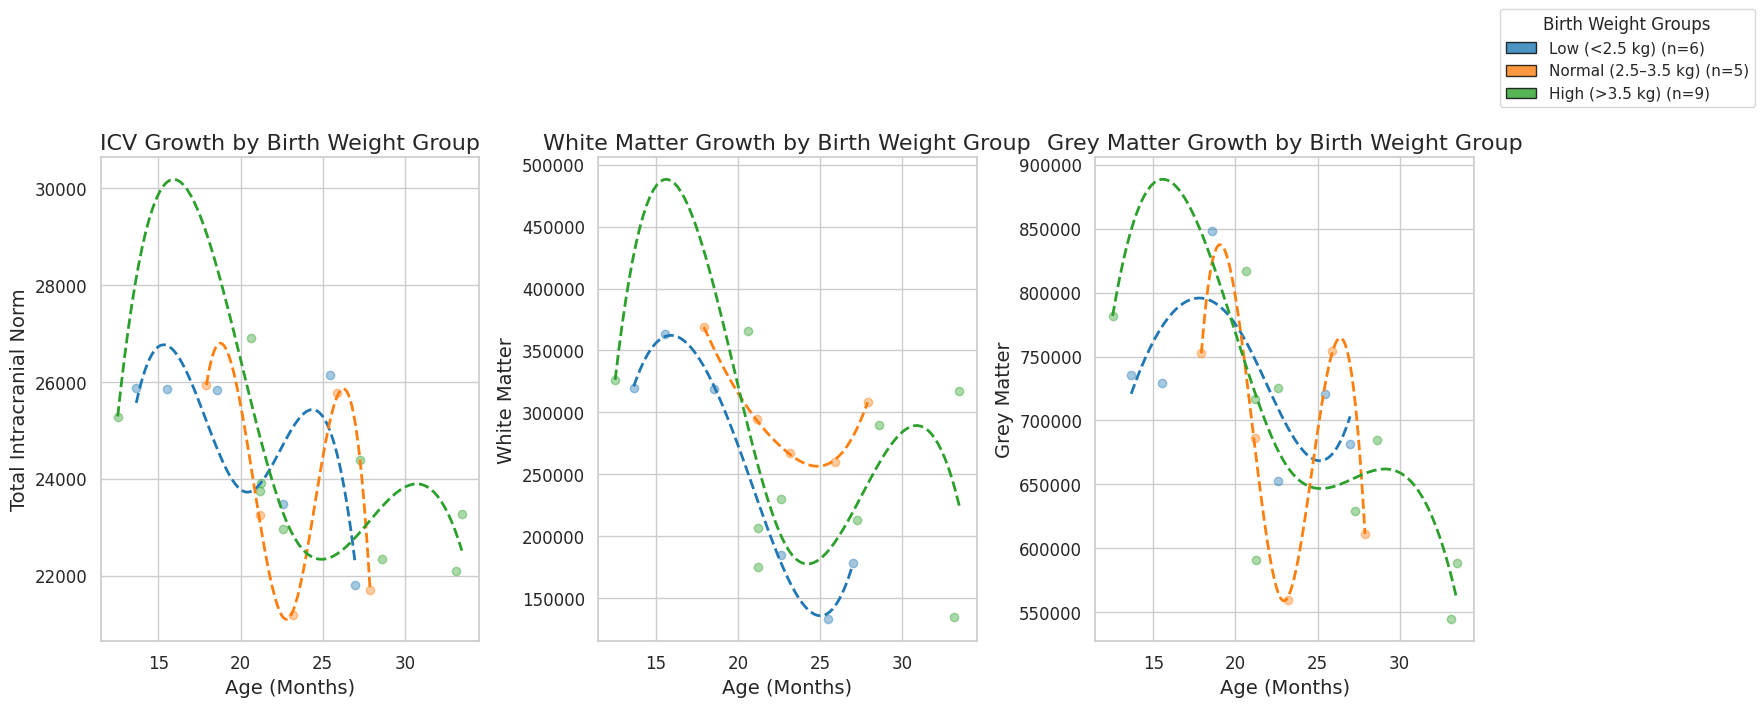

In [61]:

unity_growth_curve(combined_df)

# ------
## Misc. functions that may be usful

**# Get list of column headers**

In [102]:
# Get list of column headers
column_headers = df.columns.tolist()

print(column_headers)

['subject', 'session', 'age', 'sex', 'group', 'weight', 'total intracranial']


**Remove subject (i.e. phantom scans)**

In [ ]:
df = df[df['Subject Label'] != '137-0031']

**Harmonising categorical data to be all lower or uppercase**
In some cases, data can be inhomogenous due to erroneous inputs by users. For instance, in the sex column, you can have "m", and "M" for male. These will be treated as different categories. One way to fix this is to transform everything to upper (or lower) case.

Other functions include: ```title()``` (first letter in uppercase and rest in lowercase), or ```lower()```

In [ ]:
df['sex'] = df['sex'].str.upper()
#verify that the new catgories are M and F.
df['sex'].value_counts()

Sometimes you need to rename columns to be more intuitive

In [ ]:
df.rename(columns = {'age':'age_in_days','weight':'weight (kg)'}, inplace = True)
df.head()

Check for duplicate data, then clean them out of the dataset:

In [ ]:
sum(df.duplicated())
df2 = df[~df.duplicated()]
sum(df2.duplicated()) # calculate the number of duplicates after removing them. If we were succcessful, it should print 0.

**Merging dataframes**

In [ ]:
# Make sure each df have matching column headers - rename if necessary
df_qc = df_qc.rename(columns={'Subject Label': 'subject', 'Session Label': 'session'})

# Merge the DataFrames on 'subject' and 'session'
merged_df = pd.merge(df_qc, df, on=['subject', 'session'], how='inner')

## Outliers

To remove outliers, you can use techniques like the interquartile range (IQR) method or z-score filtering.

In [2]:
def filter_outliers(df, column):

    Q1_weight = df[column].quantile(0.25)
    Q3_weight = df[column].quantile(0.75)
    IQR_weight = Q3_weight - Q1_weight
    lower_bound_weight = Q1_weight - 1.5 * IQR_weight
    upper_bound_weight = Q3_weight + 1.5 * IQR_weight

    filtered_df = df[
        (df[column] >= lower_bound_weight) & (df[column] <= upper_bound_weight)
    ]

    return filtered_df